In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [2]:
def feature_selection(data, label, top_attribute):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k='all')
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    
    # creating columns names for the selected features
    data = data.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(ranked_features['Predictors'].tolist()[:top_attribute])
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return data

In [3]:
adaboost_df      = pd.read_csv('AdaBoost Dataset.csv',parse_dates=[0])
xgboost_df       = pd.read_csv('XGBoost Dataset.csv',parse_dates=[0])
bagging_df       = pd.read_csv('Bagging Dataset.csv',parse_dates=[0])
random_forest_df = pd.read_csv('Random Forest Dataset.csv',parse_dates=[0])

adaboost_df      = adaboost_df.set_index('Date')
xgboost_df       = xgboost_df.set_index('Date')
bagging_df       = bagging_df.set_index('Date')
random_forest_df = random_forest_df.set_index('Date')

In [4]:
def generate_optimisation_heatmap(dataset, algorithm):
    split_rmse = []
    for i in tqdm(range(1,len(dataset.columns))):
        data = feature_selection(dataset, label='PCI', top_attribute=i)
            
        X = data.iloc[:,:-1].values
        y = data.iloc[:,-1:].values
        
        for j in np.arange(0.1,0.4,0.05):
            from sklearn.model_selection import train_test_split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=42,shuffle=False)
                
            if algorithm == 'AdaBoost':
                from sklearn.tree import DecisionTreeRegressor
                from sklearn.ensemble import AdaBoostRegressor
                regr = AdaBoostRegressor(random_state=0, n_estimators=100)
                regr.fit(X_train, y_train)
                
            elif algorithm == 'Random Forest':
                from sklearn.ensemble import RandomForestRegressor
                regr = RandomForestRegressor(max_depth=2, random_state=0)
                regr.fit(X_train, y_train)
                
            elif algorithm == 'XGBoost':
                from xgboost import XGBRegressor
                regr = XGBRegressor(objective='reg:squarederror')
                regr.fit(X_train, y_train)
                
            elif algorithm == 'Bagging':
                from sklearn.tree import DecisionTreeRegressor
                from sklearn.ensemble import BaggingRegressor
                regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
                regr.fit(X_train, y_train)
        
            from sklearn.metrics import mean_squared_error
            rmse = mean_squared_error(y_test, regr.predict(X_test), squared=False) 
            predictor = data.columns[:-1].values
            split_rmse.append([i, j, rmse])
            
    optimised_df = pd.DataFrame(split_rmse,columns = ['No Attributes', 'Test Split', 'RMSE'])
    aggregated_optimised_df = optimised_df.groupby(['No Attributes', 'Test Split']).agg({'RMSE':'mean'}).reset_index()
    
    import seaborn as sns
    reshaped_df = aggregated_optimised_df.pivot(index='No Attributes', columns='Test Split',values='RMSE')
    
    percent_test_size =[]
    for i in range(len(reshaped_df.columns)):
        percent_test_size.append('{percent:.1%}'.format(percent=reshaped_df.columns[i]))
    
    #cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    ax = sns.heatmap(reshaped_df, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size).invert_yaxis()
    plt.title(str(algorithm)+'\nSplit Size vs Number of Attributes')
    optimised_parameters = aggregated_optimised_df[aggregated_optimised_df['RMSE'] == min(aggregated_optimised_df['RMSE'])].reset_index()
    print('The recommended parameter is test size = {percent:.1%}'.format(percent=optimised_parameters['Test Split'][0]), '& No of top attributes = ',optimised_parameters['No Attributes'][0])

100%|██████████| 16/16 [00:02<00:00,  6.25it/s]


The recommended parameter is test size = 20.0% & No of top attributes =  8


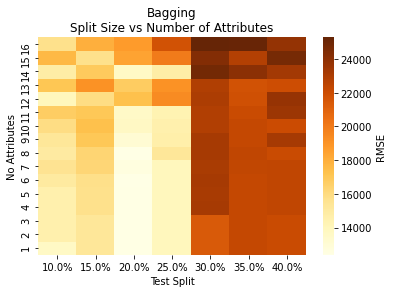

In [5]:
generate_optimisation_heatmap(bagging_df,'Bagging')

100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


The recommended parameter is test size = 20.0% & No of top attributes =  1


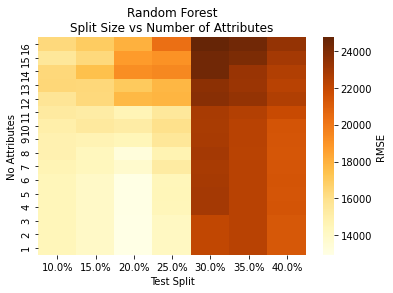

In [6]:
generate_optimisation_heatmap(random_forest_df,'Random Forest')

100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


The recommended parameter is test size = 25.0% & No of top attributes =  1


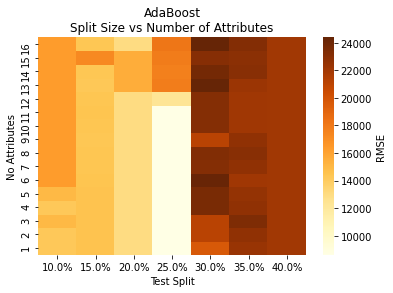

In [7]:
generate_optimisation_heatmap(adaboost_df,'AdaBoost')

100%|██████████| 16/16 [00:04<00:00,  3.54it/s]


The recommended parameter is test size = 25.0% & No of top attributes =  4


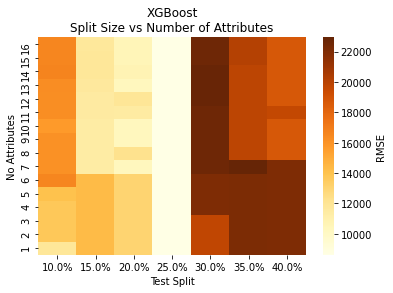

In [8]:
generate_optimisation_heatmap(xgboost_df,'XGBoost')